##### Copyright 2021 The TensorFlow Authors.

In [28]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer Learning for the Audio Domain with TensorFlow Lite Model Maker
<!-- 
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/audio_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>

</table> -->


This notebook has been built based on [this one](https://colab.research.google.com/github/googlecodelabs/odml-pathways/blob/main/audio_classification/colab/model_maker_audio_colab.ipynb) to train a custom audio classification model with sounds of RENFE trains for Soundless mobile app to measure the impact of noise on human health in Tarragona city.

This notebook can be taken as part as the necessary work to train a model with new audios as required. The Model Maker library uses transfer learning to simplify the process of training a TensorFlow Lite model using a RENFE train sounds custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data and time required.

You'll use the dataset to export a TFLite model that can be used on a phone, a TensorFlow.JS model that can be used for inference in the browser and also a SavedModel version that you can use for serving.


## Intalling dependencies


In [29]:
!pip install tflite-model-maker gdown

## Import TensorFlow, Model Maker and other libraries

Among the dependencies that are needed, you'll use TensorFlow and Model Maker. Aside those, the others are for audio manipulation, playing and visualizations.

In [1]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os
from zipfile import ZipFile
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

2023-09-02 15:23:09.894526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-02 15:23:09.894560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mauricio/Python-3.9.7/tfm_retrain_mm/soundless.audioclassification.api/soundless.audioclassification.api.env/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warning

TensorFlow Version: 2.8.0
Model Maker Version: 0.3.4


## Explore the data

In order to use this notebook it is imperative to split data into train and test folders. Then, in each of those folders, set the categories inside with the audios that should be all mono and with 16kHz sample rate.

train/<Br>
..category 1<Br>
.... *.wav<Br><Br>
test/<Br>
..category 1<Br>
.... *.wav

In [2]:
user_base_path = os.path.expanduser("~") + '/Soundless'
user_training_path = user_base_path + '/Training'
models_path = user_base_path + '/Models/'

In [3]:
test_files = os.path.abspath(os.path.join(user_training_path, 'test/*/*.wav'))
train_files = os.path.abspath(os.path.join(user_training_path, 'train/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  print(test_list)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_data_by_path(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')
  plt.plot(audio_data)
  display(Audio(audio_data.T, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


### Playing some audio

To have a better understanding about the data, lets listen to a random audio files from the test split.

Note: later in this notebook you'll run inference on this audio for testing

['/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_014.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_108.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_026.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_084.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_053.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_090.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_045.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_065.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_105.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO D

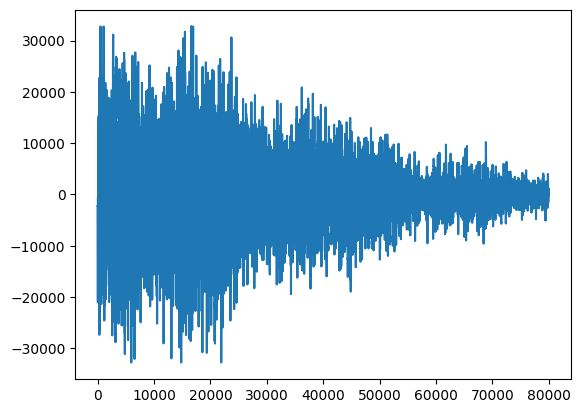

In [15]:
random_audio = get_random_audio_file()
print(random_audio)
show_data_by_path(random_audio)

## Training the Model

When using Model Maker for audio, you have to start with a model spec. This is the base model that your new model will extract information to learn about the new classes. It also affects how the dataset will be transformed to respect the models spec parameters like: sample rate, number of channels.

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier trained on the AudioSet dataset to predict audio events from the AudioSet ontology.

It's input is expected to be at 16kHz and with 1 channel.

- `frame_length` is to decide how long each traininng sample is. In this case EXPECTED_WAVEFORM_LENGTH * 3s

- `frame_steps` is to decide how far appart are the training samples. In this case, the ith sample will start at EXPECTED_WAVEFORM_LENGTH * 6s after the (i-1)th sample.

The reason to set these values is to work around some limitation in real world datasets.

In [5]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmphdhgy15b


2023-09-02 15:23:39.154292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mauricio/Python-3.9.7/tfm_retrain_mm/soundless.audioclassification.api/soundless.audioclassification.api.env/lib/python3.9/site-packages/cv2/../../lib64:
2023-09-02 15:23:39.154318: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-02 15:23:39.154337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mauricio-HP-Laptop-14-dk0xxx): /proc/driver/nvidia/version does not exist
2023-09-02 15:23:39.155048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enabl

## Loading the data

Model Maker has the API to load the data from a folder and have it in the expected format for the model spec.

The train and test split are based on the folders. The validation dataset will be created as 20% of the train split.

Note: The `cache=True` is important to make training later faster but it will also require more RAM to hold the data.

In [29]:
train_data = audio_classifier.DataLoader.from_folder(spec, os.path.join(user_training_path, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(spec, os.path.join(user_training_path, 'test'), cache=True)

In [7]:
print(train_data.size)
print(validation_data.size)
print(test_data.size)

168
43
55


## Training the model

the audio_classifier has the [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) method that creates a model and already start training it. 

You can customize many parameterss, for more information you can read more details in the documentation.

On this first try you'll use all the default configurations and train for 100 epochs.

Note: The first epoch takes longer than all the other ones because it's when the cache is created. After that each epoch takes close to 1 second.

In [40]:
batch_size = 8#train_data.size
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 2)                2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
64/64 [==============================] - 19s 272ms/step - loss: 0.5920 - acc: 0.6791 - val_loss: 0.4392 - val_acc: 0.8323
Epoch 2/100
64/64 [==============================] - 1s 7ms/step - loss: 0.4728 - acc: 0.7756 - val_loss: 0.3896 - val_acc: 0.8452
Epoch 3/100
64/64 [==============================] - 1s 8ms/step - loss: 0.4241 - acc: 0.8091 - val_loss: 0.3685 - val_acc: 0.8452
Epoch 4/100
64/64 [==============================] - 1s 7ms/step - loss: 0.4167 - acc: 0.8071 - val_loss: 0.3412 - val_acc: 0.8581
Epoch 5/100
64/64 [===============

In [41]:
print('Evaluating the model')
model.evaluate(validation_data)

Evaluating the model
5/5 [==============================] - 5s 744ms/step - loss: 0.1915 - acc: 0.9032


[0.1914863884449005, 0.9032257795333862]

## Understanding your model

When training a classifier, it's useful to see the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed knowledge of how your classifier is performing on test data.

Model Maker already creates the confusion matrix for you.

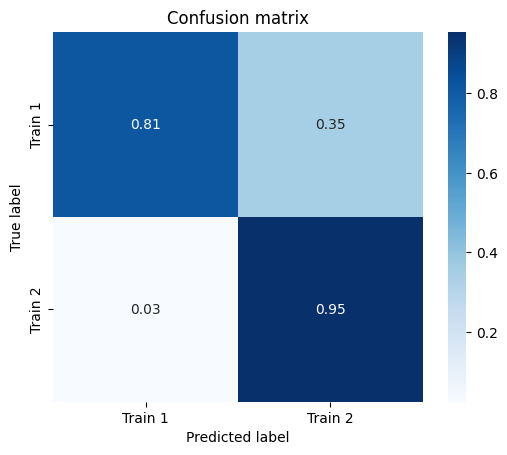

In [42]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## Testing the model [Optional]

You can try the model on a sample audio from the test dataset just to see the results.

First you get the serving model.

In [43]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'keras_layer_3')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'sequential_1')>]


Coming back to the random audio you loaded earlier

['/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_014.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_108.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_026.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_084.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_053.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_090.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_045.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_065.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_105.wav', '/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO D

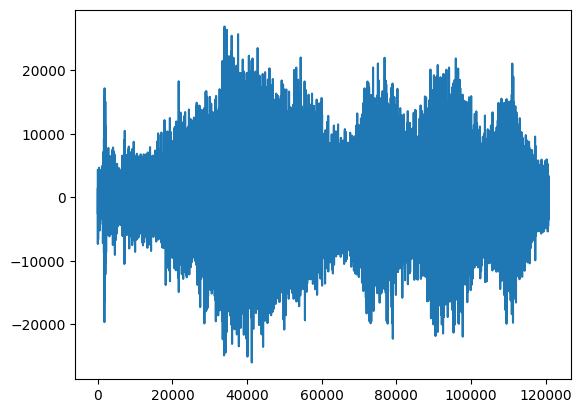

In [44]:
random_audio = get_random_audio_file()
show_data_by_path(random_audio)

The model created has a fixed input window. 

For a given audio file, you'll have to split it in windows of data of the expected size. The last window might need to be filled with zeros.

In [45]:
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

Test audio path: /home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_058.wav
Original size of the audio data: 120832
Number of windows for inference: 8


You'll loop over all the splitted audio and apply the model for each one of them.

The model you've just trained has 2 outputs: The original YAMNet's output and the one you've just trained. This is important because the real world environment is more complicated. You can use the YAMNet's output to filter out non relevant audio.

Below both outpus are printed to make it easier to understand their relation. Most of the mistakes that your model make are when YAMNet's prediction is not related to your domain.

In [46]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

/home/mauricio/Soundless/Training/test/Train 1/1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_058.wav
Result of the window ith:  your model class -> score,  (spec class -> score)
Result of the window 0: 	Train 2 -> 0.508, 	(Steam -> 0.749)
Result of the window 1: 	Train 1 -> 0.712, 	(Vehicle -> 0.870)
Result of the window 2: 	Train 1 -> 0.936, 	(Vehicle -> 0.955)
Result of the window 3: 	Train 2 -> 0.888, 	(Vehicle -> 0.830)
Result of the window 4: 	Train 1 -> 0.757, 	(Vehicle -> 0.888)
Result of the window 5: 	Train 1 -> 0.620, 	(Vehicle -> 0.730)
Result of the window 6: 	Train 1 -> 0.987, 	(Vehicle -> 0.980)
Result of the window 7: 	Train 2 -> 0.621, 	(Rail transport -> 0.665)
Mean result: Train 1 -> 0.6244364380836487


## Exporting the model

The last step is exporting your model to be used on embedded devices or on the browser.

The `export` method export both formats for you.

In [48]:
print(f'Exporting the TFLite model to {models_path}')

model.export(models_path, tflite_filename='soundless_model.tflite')

Exporting the TFLite model to /home/mauricio/Soundless/Models/
INFO:tensorflow:Assets written to: /tmp/tmp63w9jxvl/assets


INFO:tensorflow:Assets written to: /tmp/tmp63w9jxvl/assets
2023-09-02 17:13:27.204642: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-02 17:13:27.204794: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-09-02 17:13:27.256031: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 809 nodes (658), 1193 edges (1039), time = 29.048ms.
  function_optimizer: function_optimizer did nothing. time = 0.016ms.



Estimated count of arithmetic ops: 142.188 M  ops, equivalently 71.094 M  MACs


2023-09-02 17:13:28.057137: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-09-02 17:13:28.057189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-09-02 17:13:28.254580: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 142.188 M  ops, equivalently 71.094 M  MACs



INFO:tensorflow:TensorFlow Lite model exported successfully: /home/mauricio/Soundless/Models/soundless_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/mauricio/Soundless/Models/soundless_model.tflite


You can also export the SavedModel version for serving or using on a Python environment.

In [49]:
model.export(models_path, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

INFO:tensorflow:Assets written to: /home/mauricio/Soundless/Models/saved_model/assets


INFO:tensorflow:Assets written to: /home/mauricio/Soundless/Models/saved_model/assets


INFO:tensorflow:Saving labels in /home/mauricio/Soundless/Models/labels.txt


INFO:tensorflow:Saving labels in /home/mauricio/Soundless/Models/labels.txt


## Next Steps

Now the new model can be deployed on  mobile devices using [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier).

It is also possible to try the same process with additional data and  classes basing on this documentation: [Model Maker for Audio Classification](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier).

## Additional validations

Finally we can add some extra validations to check the model's performance.

In [57]:
info = []
test_list = glob.glob(test_files)

for file_path in glob.glob(test_files):
    sample_rate, audio_data = wavfile.read(file_path, 'rb')
    audio_data = np.array(audio_data) / tf.int16.max
    input_size = serving_model.input_shape[1]
    splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)
    actual_category = file_path.split("/")[6]

    results = []
    results2 = []

    for i, data in enumerate(splitted_audio_data):
        yamnet_output, inference = serving_model(data)
        results.append(inference[0].numpy())
        result_index = tf.argmax(inference[0])
        spec_result_index = tf.argmax(yamnet_output[0])
        t = spec._yamnet_labels()[spec_result_index]

        results2.append([test_data.index_to_label[result_index],
                         inference[0][result_index].numpy(),
                         spec._yamnet_labels()[spec_result_index],
                         yamnet_output[0][spec_result_index]
                         ])

    info2 = max(results2, key=lambda x: x[1])
    info.append([os.path.basename("/".join(file_path.split("/")[-3:])),
        "/".join(file_path.split("/")[-3:]),
        actual_category,
        info2[0],
        info2[1],
        info2[2],
        info2[3].numpy()])

df = pd.DataFrame(info, columns=['fname', 'filename', 'actual_category', 'got_category', 'prec', 'yamnet_category', 'yamnet_got_category'])

In [ ]:
df.query("actual_category == got_category and actual_category=='Train - Low speed'")\
    .sort_values(by=["fname"])

In [58]:
df.query("actual_category != got_category and actual_category != 'Train - Port'")\
.sort_values(by=["prec", "actual_category", "got_category"], ascending=False)

,fname,filename,actual_category,got_category,prec,yamnet_category,yamnet_got_category
47,202309021243591-88409-B-45.wav,test/Train 2/202309021243591-88409-B-45.wav,Train 2,Train 1,0.999963,Vehicle,0.977281
52,202309021243575-188945-A-45.wav,test/Train 2/202309021243575-188945-A-45.wav,Train 2,Train 1,0.999945,Vehicle,0.974849
37,202309021243583-138212-A-45.wav,test/Train 2/202309021243583-138212-A-45.wav,Train 2,Train 1,0.999812,Vehicle,0.971758
45,202309021243565-199284-B-45.wav,test/Train 2/202309021243565-199284-B-45.wav,Train 2,Train 1,0.998972,Vehicle,0.922267
46,202309021243592-122067-A-45.wav,test/Train 2/202309021243592-122067-A-45.wav,Train 2,Train 1,0.998675,Vehicle,0.990412
0,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 2,0.998674,Explosion,0.313482
4,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 2,0.997613,Vehicle,0.513645
39,202309021243582-135649-C-45.wav,test/Train 2/202309021243582-135649-C-45.wav,Train 2,Train 1,0.991837,Rail transport,0.874450
50,202309021243591-64473-A-45.wav,test/Train 2/202309021243591-64473-A-45.wav,Train 2,Train 1,0.988037,Vehicle,0.876393
42,202309021243592-135649-B-45.wav,test/Train 2/202309021243592-135649-B-45.wav,Train 2,Train 1,0.985974,Vehicle,0.962481


In [59]:
t = df.query("actual_category == got_category")['filename'].count()
f = df.query("actual_category != got_category")['filename'].count()
print(f'true: {t}, false: {f}, tot: {t/(t+f)}')

true: 44, false: 11, tot: 0.8


In [38]:
df.query("actual_category == got_category and yamnet_got_category<=1.6")\
    .sort_values(by=["actual_category", "got_category", "fname"])

,fname,filename,actual_category,got_category,prec,yamnet_category,yamnet_got_category
28,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.998768,Vehicle,0.993753
19,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.999480,Vehicle,0.946045
13,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.998623,Vehicle,0.936396
26,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.998878,Vehicle,0.290015
30,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.999907,Vehicle,0.658433
23,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.999998,Vehicle,0.970765
9,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.998311,Siren,0.265111
27,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.999627,Vehicle,0.990335
6,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.983858,Vehicle,0.839863
15,1. TRENES RENFE SONIDO DIRECTO VOL 1_segment_0...,test/Train 1/1. TRENES RENFE SONIDO DIRECTO VO...,Train 1,Train 1,0.999999,Rail transport,0.971133


In [24]:
df.sort_values(by=["yamnet_got_category"], ascending=True)\
    .groupby(['yamnet_category'])\
    .agg(count=('yamnet_category', 'count'))\
    .sort_values(by=["count"], ascending=False)

,count
yamnet_category,
Vehicle,43
Ocean,2
Rail transport,2
Explosion,1
Flap,1
Jet engine,1
"Outside, rural or natural",1
Siren,1
"Traffic noise, roadway noise",1
